# Classification exercise in HEP

In [1]:
#Load the dataset using pandas and numpy

import pandas as pd
import numpy as np
import gzip


higgsusy=2

print("higgsusy switch ",higgsusy)

if higgsusy==1:

  link='https://www.dropbox.com/s/muyqdaw17iqxlnd/susyred1.csv.gz?dl=1' 


  features=['SIG','lep_1_pT', 'lep_1_eta', 'lep_1_phi', 'lep_2_pT', 'lep_2_eta', 'lep_2_phi',
            'MET_val', 'MET_phi', 'MET_rel', 'axial_MET',  'MT2']        

  low_features=['lep_1_pT', 'lep_1_eta', 'lep_1_phi', 'lep_2_pT', 'lep_2_eta', 'lep_2_phi',
                'MET_val', 'MET_phi']

  high_features=['MET_rel', 'axial_MET', 'MT2']
                  
if higgsusy==2:

  link='https://www.dropbox.com/s/vdnstm4qo24uppn/higgsred.csv.gz?dl=1'
  
  features=['SIG','lepton_pT', 'lepton_eta', 'lepton_phi', 'MET_val', 'MET_phi', 
            'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_btag', 
            'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_btag', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag', 
            'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

  low_features=['lepton_pT', 'lepton_eta', 'lepton_phi', 'MET_val', 'MET_phi', 
            'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_btag', 
            'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_btag', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag']

  high_features=['m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

# define number of records that we want to read
N = 240000
print("Size of dataset : %i"%N)
df = pd.read_csv(link, compression='gzip', header=None,nrows=N,engine='python')
#Name the columns using the 'features' array
df.columns=features
#Inspect contents
#print(df.head)
print ("data loaded")

higgsusy switch  2
Size of dataset : 240000
data loaded


Once we have set up the libraries for creating and fitting the NN, we need to define the input vector X, including all of the columns except the label one, and the target vector including only the label.

For the X vector we prepare two  variations, the version  with only low-level variables, and the one with all of the variables. The first exercise will thn be done using the full set of variables 

In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils     import plot_model
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import warnings

In [3]:
#Define vectors for input to NN 

# Use first column as definition of target
y = df['SIG'].values

# Three different sets: full, only low features

X = df[[col for col in df.columns if col!="SIG"]]
X_low=X[low_features]
X_high=X[high_features]

We need to define a set for the training and a set for the test, sklearn provides a method which performs a splitting based on the desired size for  the test. In our case we separate 20% of the events corresponding to 48k events. After that we run the neural network. 
Note that for future ues we store the history of the traning, and the set of weights corresponding to the step with best accuracy on the test sample

In [4]:
from sklearn.model_selection import train_test_split
# create test and train samples for both full feature set, and low level features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
X_trainl, X_testl, y_trainl, y_testl = train_test_split(X_low, y, test_size=.2, random_state=0)

## Evaluating the classifier performance

### Learning curve

The performance of the network can be evaluated by inspecting the learning curve, i.e plottong  the loss for each epoch, both for the training and for the test sample. A healty situation correspond to the case where train and test follow each other as more ephochs are added, up to the moment where both flatten out.  When the  loss value for the training sample is much better than the one for the test sample we have a case of overfitting, i.e. 
the model instead of picking up generic features of the sample, it picks up noise, i.e. it tries to reproduce the features of the specific events in the training sample

In [5]:
import matplotlib.pyplot as plt

# plot the 
def plothis(history, title):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
#  plt.show()

def plothis_file(filehis, title):
  hh = pd.read_csv(filehis, header=0, engine='python')   
  plt.plot(hh['loss'].values)
  plt.plot(hh['val_loss'].values)
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
#plothis(history, 'test network')
#plothis_file(savelog, 'test network')



### Probability distributions for signal and backround

The output of the classification is for each event a number between 0 and 1 representing the probability that that event is a signal event. Since for each event we know whether it was a signal (SIG=1) or a background (SIG=0), we can plot the output probability of the network for each of the two classes
Lets do it for the model with the best preformance on the test sample, which was saved as best_model.h5: first lets load it, and then lets try to evaluate the performance of the classification.

In [6]:
def pred_model(modfile, X_test):
# load the saved model
  best_model = load_model(modfile)

#predict the output on the test sample

  Ypredt = best_model.predict(X_test)
  return Ypredt

def plot_prob(y_test, Ypredt):

    #build a dataframe with as columns the output PROB and the label (SIG)

  df_test_acc = pd.DataFrame({'PROB':Ypredt[:,0]})
  df_test_acc['SIG']=y_test

# split according to the label
  df_test_acc_bkg = df_test_acc.query('SIG==0')
  df_test_acc_sig = df_test_acc.query('SIG==1')
  print('nsig ',df_test_acc_sig.shape[0])
  print('nbkg ',df_test_acc_bkg.shape[0])

  bins = np.linspace(0, 1,50)
  plt.hist(df_test_acc_bkg.PROB, bins, alpha=0.5, density=True, label='Background')
  plt.hist(df_test_acc_sig.PROB, bins, alpha=0.5, density=True, label='Signal')
  plt.legend(loc='best')
  plt.show()


#plot
#  fig, axes = plt.subplots(1, 2, figsize=(14,5))
#  df_test_acc_sig.plot(kind='hist', ax=axes[0], y='PROB',color='blue',bins=np.linspace(0,1,100),label='Signal')
#  axes[0].set(xlabel="PROB", ylabel="Frequency")
#  df_test_acc_bkg.plot(kind='hist',ax=axes[1], y='PROB',color='red',bins=np.linspace(0,1,100),label='Background')
#  axes[1].set(xlabel="PROB", ylabel="Frequency")
#  plt.show()


### Receive Operating Characteristic (ROC) Curve

In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

def plot_roc_base(y_test, Ypredt, labroc):
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, Ypredt)
  auc_keras = auc(fpr_keras, tpr_keras)
  print(labroc," auc ",auc_keras)
  plt.plot(fpr_keras, tpr_keras, label=labroc+' AUC = {:.3f}'.format(auc_keras))

def plot_roc_single(y_test, Ypredt, labroc):
   plt.plot([0.001, 1], [0, 1], 'k--')
   plot_roc_base(y_test, Ypredt, labroc)
   plt.xlabel('False positive rate')
   plt.ylabel('True positive rate')
   plt.legend(loc='best')
   plt.show    
    

#plot_roc_single(y_test,Ypredt, 'test sample')



### Discovery significance in HEP

In a typical classification task one evaluates the values of TPR and FPR for PROB=0.5.

In HEP the situation is different. As already explained, we typically have a number of background events which is several order of magnitude larger than the signal, and we want to define a selection which maximises the statistical significance for observing a signal $s$ over a known background $b$. 

Ignoring the uncertainty on the background estimate, the sensitivity, based  on profile likelihood ratio test (following e.g. http://www.pp.rhul.ac.uk/~cowan/atlas/cowan_statforum_8may12.pdf, the published paper is https://arxiv.org/pdf/1007.1727.pdf ) can be written as: 

In [8]:
from numpy import sqrt
from math import log
from numpy import nanmax

#
#  calculate significance based on asymptotic formulas 
#
def calc_sig(nsig, nbg, nbExpEr):
    nbObs=nsig+nbg
    nbExp=nbg
    if nbExp>0 and nbExpEr>0:
      factor1 = nbObs*log( (nbObs*(nbExp+nbExpEr**2))/(nbExp**2+nbObs*nbExpEr**2) )
      factor2 = (nbExp**2/nbExpEr**2)*log( 1 + (nbExpEr**2*(nbObs-nbExp))/(nbExp*(nbExp+nbExpEr**2)) )
      signi  = sqrt(2*(factor1 - factor2))
    if nbExp>0 and nbExpEr==0:
      signi=sqrt(2*((nsig+nbg)*log(1+nsig/nbg)-nsig))
    if nbExp==0 and nbExpEr==0:
      signi=sqrt(nsig)
    if nbExp==0 and nbExpEr>0:
      signi=nsig/sqrt(nbExpEr)
    return signi
#
#   calculate significance for a discriminator yielding
#   predictions Ypredt for labels y_test, assuming
#   nsigtot:  number of signal events before selection
#   nbgtot: nuber of background events before selection
#   errfbg: fractional systematic uncertainty on background
#
def plot_signi_base(y_test, Ypredt, nsigtot, nbgtot, errfbg, lab):
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, Ypredt)
  n_bg=fpr_keras*nbgtot
  n_sig=tpr_keras*nsigtot
  errbg=errfbg*n_bg
  signi=[]
  thr=[]      
  for i in range(1,len(n_sig)):
      if(thresholds_keras[i]>0.):
        signi.append(calc_sig(n_sig[i],n_bg[i],errbg[i]))
        thr.append(thresholds_keras[i])        
  imax=-1
  signimax=0.
  for i in range(0,len(signi)):
     if signi[i]>signimax:
        imax=i
        signimax=signi[i]  
  maxs=nanmax(signi)
  print(lab+":") 
  print(" max significance is  ",signimax," nbg ",n_bg[imax]," nsig ",n_sig[imax]," cut ",thresholds_keras[imax])
  print(" background efficiency: ", n_bg[imax]/nbgtot," signal efficiency: ", n_sig[imax]/nsigtot )
  plt.plot(thr,signi, label=lab)
    
  plt.xlabel('Cut on PROB')
  plt.ylabel('Significance')


  return thr, signi, imax

### Inspection of the impact of selection on variables

In order to understand what the NN does, it can be useful to plot the distribution of the variables for accepted and rejected events, and their correlations.

In [9]:
# create dataframe adding probability of selector and label to X_test
#df_test_plot=X_test.copy(deep=True)
#df_test_plot['PROB']=Ypredt
#df_test_plot['SIG']=y_test


In [10]:
def plot_varsel(df, sel1, sel2, var, blow, bhigh, nbin):
  df_pass = df.query(sel1)
  df_nopass = df.query(sel2)
  bins = np.linspace(blow, bhigh, nbin)
  plt.hist(df_pass[var], bins, alpha=0.5, density=True, label=sel1)
  plt.hist(df_nopass[var], bins, alpha=0.5, density=True, label=sel2)
  plt.legend(loc='best')
  plt.xlabel(var)
  plt.ylabel('normalised events')
  plt.show()


In [11]:
def plot_scat(df, sel1, sel2, var1, var2, blx, bhx, bly, bhy):
  df_pass = df.query(sel1)
  df_nopass = df.query(sel2) 
  fig= plt.figure(figsize=(14,5))
  plt.subplot(1, 2,1)
  plt.xlim([blx,bhx])
  plt.ylim([bly,bhy])
  plt.plot(df_nopass[var1], df_nopass[var2], 'bo', alpha=0.4, label=sel2)
  plt.legend(loc='best')
  plt.xlabel(var1)
  plt.ylabel(var2)
  plt.subplot(1, 2,2)
  plt.xlim([blx,bhx])
  plt.ylim([blx,bhx])
  plt.plot(df_pass[var1], df_pass[var2], 'ro', alpha=0.4, label=sel1)
  plt.legend(loc='best')
  plt.xlabel(var1)
  plt.ylabel(var2)
  plt.show()

#plot_scat(df_test_plot, sel3, sel4, 'm_bb', 'm_wwbb', 0, 5, 0, 5)
#plot_scat(df_test_plot, sel1, sel2, 'm_bb', 'm_wwbb', 0, 5, 0, 5)

In [12]:
def plot_2d(df, sel1, sel2, var1, var2, nbx, blx, bhx, nby, bly, bhy):
  df_pass = df.query(sel1)
  df_nopass = df.query(sel2) 
  binsx = np.linspace(blx, bhx, nbx)
  binsy = np.linspace(bly, bhy, nby)
  fig= plt.figure(figsize=(14,5))
  plt.subplot(1, 2,1)
  plt.hist2d(df_nopass[var1], df_nopass[var2], bins=[binsx, binsy], density=False, cmin=0.5)
  plt.title(sel2)
  plt.xlabel(var1)
  plt.ylabel(var2)
  plt.subplot(1, 2,2)
  plt.hist2d(df_pass[var1], df_pass[var2], bins=[binsx,binsy],  density=False, cmin=0.5)
  plt.title(sel1)
  plt.xlabel(var1)
  plt.ylabel(var2)
  plt.show()



After learning how to evaluate the results of a DNN classifier, based on a validation sample split out
of the trainig sample, we load in independent sample of 100k events, on which we want to study the performance 
of different variantions  of the classifier

In [13]:
import os

print("start loading test samples")


linkxl='https://www.dropbox.com/s/b2o0x1ybnodgrr8/100k_X_testl.csv.gz?dl=1'
linkyl='https://www.dropbox.com/s/banybphgceqw7dj/100k_y_testl.csv.gz?dl=1'
linkx='https://www.dropbox.com/s/bs6qhvr5e68ljp3/100k_X_test.csv.gz?dl=1'
linky='https://www.dropbox.com/s/6r6vlwr4uycyfpn/100k_y_test.csv.gz?dl=1'

N=100000
df_x_l = pd.read_csv(linkxl, compression='gzip', header=None,nrows=N,engine='python')
df_y_l = pd.read_csv(linkyl, compression='gzip', header=None,nrows=N,engine='python')
X_testal=df_x_l.values
y_testal=df_y_l.values
df_x = pd.read_csv(linkx, compression='gzip', header=None,nrows=N,engine='python')
df_y = pd.read_csv(linky, compression='gzip', header=None,nrows=N,engine='python')
X_testa=df_x.values
y_testa=df_y.values

print("Test samples loaded")


start loading test samples
Test samples loaded


## Results on 240k sample 

The four variations of the model we are looking at, following the work of Baldi et al are:
    
* A shallow network with a single hiden layer using as input only low level variables

* A shallow network with a single hidden layer using both low level and high level variables

* A deep network with a 6 hiden layers using as input only low level variables

* A deep network with 6 hidden layer using both low level and high level variables

The way the networks were trained is shown commented in the cell below. Differently from the model we have trained on the, spot, in this case we let an 'early stop' algorithm decide when to stop the training. This means that the four optimisations take some time, so we performed the trainig offline and we saved the output model on file 

In [14]:
import os

print('loading models')
if(os.path.exists('240k_mod_deep_all.h5')==False):
  os.system('wget https://www.dropbox.com/s/ernqamitd2n0m32/240k_mod_deep_all.h5')
if(os.path.exists('240k_mod_deep_low.h5')==False):
  os.system('wget https://www.dropbox.com/s/uwnj21cfd4j3i5g/240k_mod_deep_low.h5')
if(os.path.exists('240k_mod_shallow_all.h5')==False):
  os.system('wget https://www.dropbox.com/s/96xvaft927nvxwn/240k_mod_shallow_all.h5')
if(os.path.exists('240k_mod_shallow_low.h5')==False):
  os.system('wget https://www.dropbox.com/s/w0b6o1r5b41te8d/240k_mod_shallow_low.h5')
print('models loaded')

Ypred1s=pred_model("240k_mod_deep_all.h5", X_test)
Ypred2s=pred_model("240k_mod_shallow_all.h5", X_test)
Ypred3s=pred_model("240k_mod_deep_low.h5", X_testal)
Ypred4s=pred_model("240k_mod_shallow_low.h5", X_testal)

loading models
models loaded


## Results on 11M sample

All the exercises above were performed by trainig on a 240k events sample which is split 80% in a trainid and 20% on a validation sample.  This was done in order to have a reasonable running time for the hands-on exercises

It is interesting, though, also to see the performance on the full HIGGS sample, made of 11M events, comparing the performance for low-level variables and for the full set of features including the invariant mass variables, and how different is the performance of a shallow neural network with a single input layer  is with respect to a deep network with 5 layers.

You can try to obtain the same result yourselves, but you will need a powerful machine with lots of memory. 

In [15]:
import os
import os.path

print('loading models')
if(os.path.exists('11M_nor_mod_deep_all.h5')==False):
  os.system('wget https://www.dropbox.com/s/lthto3apjbru22u/11M_nor_mod_deep_all.h5')
if(os.path.exists('11M_nor_mod_deep_low.h5')==False):
  os.system('wget https://www.dropbox.com/s/rshcgkte1lq5ofy/11M_nor_mod_deep_low.h5')
if(os.path.exists('11M_nor_mod_shallow_all.h5')==False):
  os.system('wget https://www.dropbox.com/s/fcf9vwawfmu8ygb/11M_nor_mod_shallow_all.h5')
if(os.path.exists('11M_nor_mod_shallow_low.h5')==False):
  os.system('wget https://www.dropbox.com/s/zhck75rbuzqoxz1/11M_nor_mod_shallow_low.h5')
print('models loaded')


Ypred1s_11M=pred_model("11M_nor_mod_deep_all.h5", X_test)
Ypred2s_11M=pred_model("11M_nor_mod_shallow_all.h5", X_test)


loading models
models loaded


## An alternative approach for comparison: Boosted Decision Tree
 
The present default approac in LHC analyses for cases where discriminatin of signal from background is difficult is the use of boosted decision trees (BDT). The tool typically used is the TMVA packge implemented in ROOT. We will use in this notebook XGB, a version of BDT which has shown very good performance in various competition, with the aim of comparint it to the DNN approach. 
For the definition of the tool I will use some very clear slides avalable at:
https://indico.fnal.gov/event/15356/contributions/31377/attachments/19671/24560/DecisionTrees.pdf

In [16]:
import xgboost as xgb
import time
print(xgb.__version__)

#Use default parameters and train on full dataset
XGBclassifier = xgb.sklearn.XGBClassifier(nthread=4, seed=1, objective='binary:logistic', 
                                          eta=0.05, max_depth=10, n_estimators=100)
#Train and time classifier
start_time = time.time()
eval_set = [(X_train, y_train), (X_test, y_test)]
XGBclassifier.fit(X_train, y_train, eval_metric=["logloss"], eval_set=eval_set,verbose=True  )
run_time = time.time() - start_time

#XGBclassifier.save_model('xgb_test')


1.3.3


/home/polesell/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68025	validation_1-logloss:0.68172
[1]	validation_0-logloss:0.66845	validation_1-logloss:0.67136
[2]	validation_0-logloss:0.65762	validation_1-logloss:0.66193
[3]	validation_0-logloss:0.64766	validation_1-logloss:0.65341
[4]	validation_0-logloss:0.63847	validation_1-logloss:0.64554
[5]	validation_0-logloss:0.62979	validation_1-logloss:0.63821
[6]	validation_0-logloss:0.62171	validation_1-logloss:0.63150
[7]	validation_0-logloss:0.61420	validation_1-logloss:0.62533
[8]	validation_0-logloss:0.60716	validation_1-logloss:0.61959
[9]	validation_0-logloss:0.60074	validation_1-logloss:0.61436
[10]	validation_0-logloss:0.59441	validation_1-logloss:0.60933
[11]	validation_0-logloss:0.58868	validation_1-logloss:0.60475
[12]	validation_0-logloss:0.58305	validation_1-logloss:0.60038
[13]	validation_0-logloss:0.57765	validation_1-logloss:0.59631
[14]	validation_0-logloss:0.57271	validation_1-logloss:0.59257
[15]	validation_0-logloss:0.56779	validation_1-logloss:0.58892
[1

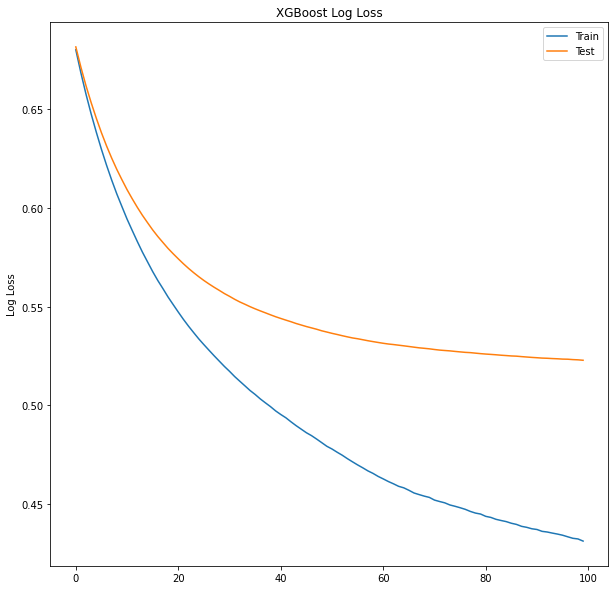

Predicting on 48000 examples with 28 features

43.05266356468201
xgb  auc  0.8155669590632966


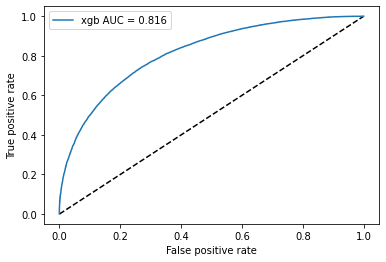

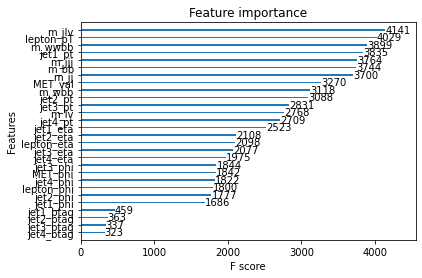

In [17]:
import os
#Make Predictions
# retrieve performance metrics
#if(os.path.exists('xgb_11M_200.json')==False):
if(os.path.exists('xgb_11M_200.json')==False):
  os.system('wget https://www.dropbox.com/s/bf0to4fuqrk2m8w/xgb_11M_200.json')
XGBfile = xgb.sklearn.XGBClassifier()  # init model
XGBfile.load_model('xgb_11M_200.json')  # load data

results = XGBclassifier.evals_result()
#results = XGBfile.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
    
# plot log loss
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
    
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
    
print("Predicting on %i examples with %i features\n"%X_test.shape)
Ypredx= XGBclassifier.predict_proba(X_test)[:,1]
Ypredx11M= XGBfile.predict_proba(X_test)[:,1]
#Ypredx11M=Ypredx

print(run_time)
plot_roc_single(y_test,Ypredx,"xgb") 

xgb.plot_importance(XGBclassifier,grid=False);

all deep  auc  0.8203426006205239
all shal  auc  0.7870395591061576
xgb  auc  0.8155669590632966
all deep:
 max significance is   1.9926711178833862  nbg  102.22515972681208  nsig  23.48152539023908  cut  0.88582134
 background efficiency:  0.020445031945362416  signal efficiency:  0.2348152539023908
all shal:
 max significance is   1.4445044142115344  nbg  180.8768451200705  nsig  24.003161430547323  cut  0.81836367
 background efficiency:  0.0361753690240141  signal efficiency:  0.24003161430547323
xgb:
 max significance is   2.1187091169973553  nbg  14.76096056400088  nsig  8.982414542580518  cut  0.92004454
 background efficiency:  0.002952192112800176  signal efficiency:  0.08982414542580518


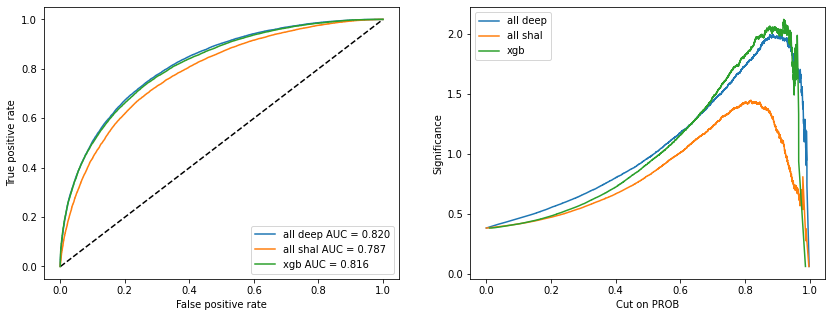

In [18]:
fig= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
plt.plot([0.001, 1], [0, 1], 'k--')
plot_roc_base(y_test,Ypred1s,"all deep")
plot_roc_base(y_test,Ypred2s,"all shal") 
plot_roc_base(y_test,Ypredx,"xgb") 
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

plt.subplot(1, 2,2)
thr, signi, imax=plot_signi_base(y_test, Ypred1s, 100, 5000, 0.05, 'all deep')
thr, signi, imax=plot_signi_base(y_test, Ypred2s, 100, 5000, 0.05, 'all shal')
#thr, signi, imax=plot_signi_base(y_testal, Ypred3s, 100, 5000, 0.05, 'low deep')
#thr, signi, imax=plot_signi_base(y_testal, Ypred4s, 100, 5000, 0.05, 'low shal')
thr, signi, imax=plot_signi_base(y_test, Ypredx, 100, 5000, 0.05, 'xgb')
plt.legend(loc='best')
plt.show()

plt.show()

all deep  auc  0.8823321879764385
all shal  auc  0.837359160737352
xgb  auc  0.8379327463809121
all deep:
 max significance is   4.065569742549867  nbg  1.762502753910553  nsig  6.488836198379768  cut  0.9890628
 background efficiency:  0.0003525005507821106  signal efficiency:  0.06488836198379767
all shal:
 max significance is   2.3175317620826714  nbg  4.626569729015202  nsig  5.579924916024502  cut  0.96572256
 background efficiency:  0.0009253139458030404  signal efficiency:  0.055799249160245014
xgb:
 max significance is   2.604182072290318  nbg  0.22031284423881914  nsig  1.9403279984192847  cut  0.97097033
 background efficiency:  4.406256884776383e-05  signal efficiency:  0.019403279984192848


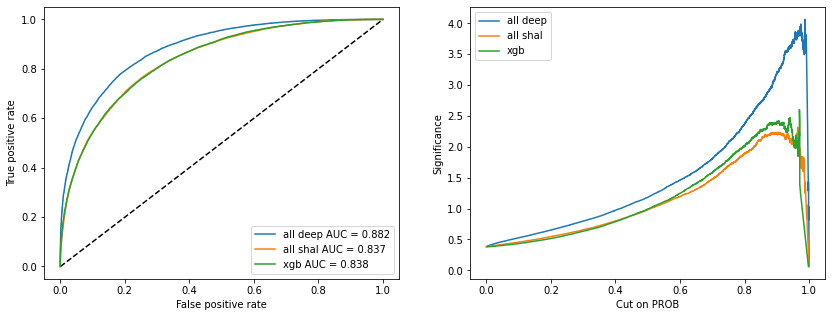

In [19]:
fig= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
plt.plot([0.001, 1], [0, 1], 'k--')
plot_roc_base(y_test,Ypred1s_11M,"all deep")
plot_roc_base(y_test,Ypred2s_11M,"all shal") 
plot_roc_base(y_test,Ypredx11M,"xgb") 
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

plt.subplot(1, 2,2)
thr, signi, imax=plot_signi_base(y_test, Ypred1s_11M, 100, 5000, 0.05, 'all deep')
thr, signi, imax=plot_signi_base(y_test, Ypred2s_11M, 100, 5000, 0.05, 'all shal')
#thr, signi, imax=plot_signi_base(y_testal, Ypred3s, 100, 5000, 0.05, 'low deep')
#thr, signi, imax=plot_signi_base(y_testal, Ypred4s, 100, 5000, 0.05, 'low shal')
thr, signi, imax=plot_signi_base(y_test, Ypredx11M, 100, 5000, 0.05, 'xgb')
plt.legend(loc='best')
plt.show()

plt.show()